In [1]:
import pandas as pd
import numpy as np
import os
import paramiko
from modeling.utils import read_table, get_engine
from data_ingestion import update_roster, update_team_stats, update_player_stats
from datetime import date
from modeling.covid_recovery import NBACovid
from modeling.chance_of_victory import NBACoV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import query
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_file(file):
    if not os.path.exists(file):
        ssh = paramiko.SSHClient()
        ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh.connect(hostname='129.153.2.48', username='team', password='NBACovid19!')
        with ssh.open_sftp() as sftp:
            sftp.get(f'/mnt/ml-nba/models/{file}', f'./{file}')
        ssh.close()

# Database
Manages updating stats as games occur
3 Tables to continually update
* Player Stats
* Team Stats
* Active Roster

In [3]:
day = date(2022, 1, 5)
games = read_table(query.games_date, today=day)

### Player Stats
Replaces player stats with up to date stats

In [4]:
with get_engine().begin() as conn:
    update_player_stats(games, connection=conn)
    player_id = read_table(query.random_player, game_date=day, connection=conn).loc[0, 'player_id']
    old_df = read_table(query.old_player, player=player_id, connection=conn)
    new_df = read_table(query.new_player, player=player_id, connection=conn)

In [5]:
df = pd.concat((old_df, new_df), axis=0, ignore_index=True)
df.index = ['Original', 'Updated']
df

,player_id,pts,orb,ast
Original,barnesc01,14.7,2.5,3.4
Updated,barnesc01,15.3,2.6,3.5


### Team Stats
Replaces team stats with up to date stats

In [6]:
with get_engine().begin() as conn:
    update_team_stats(games, connection=conn)
    team = read_table("select team from TEAM_STATS", connection=conn).loc[1, 'team']
    df = read_table("select * from TEAM_STATS where team = :team", team=team, connection=conn)

In [7]:
df.index = ['Updated']
df

,team,conf,div,w,l,W/L%,mov,ortg,drtg,nrtg,MOV/A,ORtg/A,DRtg/A,NRtg/A,season
Updated,Boston Celtics,E,A,51,31,0.622,7.28,115.37,107.71,7.66,7.02,115.05,107.65,107.65,2022


### Active Roster
Adds rows to active roster with new actives and inactives

In [10]:
with get_engine().connect() as conn:
    df = update_roster(games, conn)
    df = df[['game_date', 'player', 'player_id', 'active', 'covid']]

In [11]:
df.head()

,game_date,player,player_id,active,covid
0,2022-01-05,Gary Trent Jr.,None,1,0
1,2022-01-05,DeMarcus Cousins,couside01,1,0
2,2022-01-05,Fred VanVleet,vanvlfr01,1,0
3,2022-01-05,Khris Middleton,middlkh01,1,0
4,2022-01-05,Jrue Holiday,holidjr01,1,0


# Modeling
2 Models
* Chance of Victory
* Covid Recovery

### Chance of Victory
Binary Classification Model between Home and Away

In [27]:
win_model = NBACoV('classifier_v2')

In [13]:
X = win_model.inference_table(date(2022, 2, 5))
y = win_model.predict(X.iloc[:, 3:])

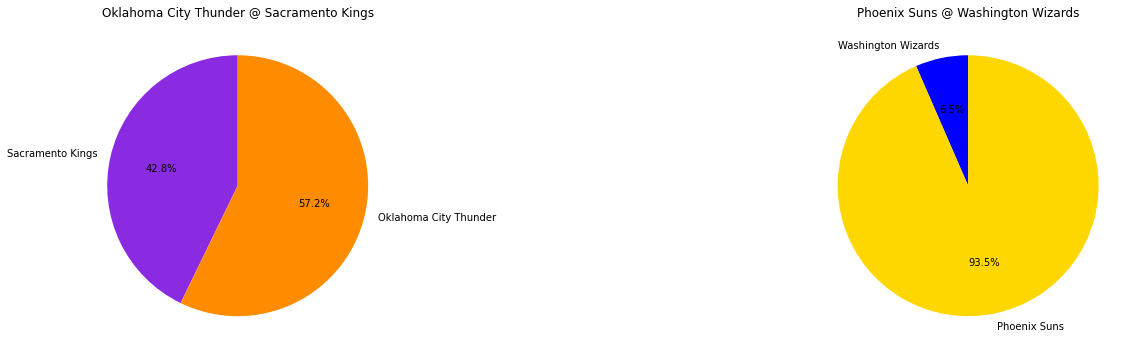

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(24,6))
colors = [['blueviolet', 'darkorange'], ['blue', 'gold']]
for i in range(2):
    labels = [X.iloc[i, 1], X.iloc[i, 2]]
    scores = [y[i], 1 - y[i]]
    axes[i].pie(scores, labels=labels, startangle=90, colors=colors[i], autopct='%1.1f%%')
    axes[i].title.set_text(f'{X.iloc[i,2]} @ {X.iloc[i,1]}')
plt.show()

In [15]:
print('Sportsbook Spread Accuracy: 68%')
read_table('win_performance.sql').head()

Sportsbook Spread Accuracy: 68%


,Total Accuracy,60% Win Probability Performance,70% Win Probability Performance,80% Win Probability Performance,90% Win Probability Performance
0,0.690244,0.710451,0.741203,0.785928,0.850242


### Covid Recovery
Time Series Regression Model, clipped to [0,1]

In [16]:
model = NBACovid('nbeats_50.pt')
def health(player_id, name):
    games = read_table(query.games, player_id=player_id)
    healths = []
    for game in games.game_date[1:]:
        healths.append(model.predict(model.load_data(game, player_id)))
    real = read_table("select game_date, health from nba.ACTIVE_ROSTER_DUMMY where PLAYER_ID = :player_id order by 1", player_id=player_id, index_col='game_date')
    plt.plot(games.game_date[1:], healths, color='red', label='pred')
    plt.plot(real, color='green', label='real')
    plt.legend()
    plt.title(f'{name} Health')
    plt.show()
    print(f'MSE Score: {mean_squared_error(healths, real.loc[games.game_date[1:],"health"])}')

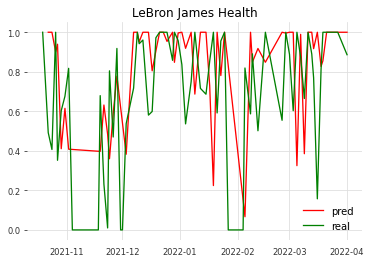

MSE Score: 0.1050756119774548


In [17]:
health('jamesle01', 'LeBron James')

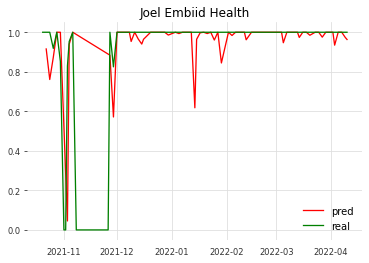

MSE Score: 0.014130485612570439


In [18]:
health('embiijo01', 'Joel Embiid')

### Full Model Pipeline
Health Model predicts health -> multiplier for individual players' stats -> accumulate stats into inference table -> predict win probability

In [19]:
game_date = date(2021, 11, 28)    # Pick arbitrary date
game_idx = 3                    # Select game
game = read_table('select * from SCHEDULE where GAME_DATE = :game_date', game_date=game_date)

Covid Recovery Model predicts the health of each player for the next game using labeled health values
The Model predicts one step at a time so autoregressive predictions are made from the last game until the next game

In [20]:
away_stats = read_table('stats.sql', game_date=game_date, team=game.away[game_idx], season=2022)
home_stats = read_table('stats.sql', game_date=game_date, team=game.home[game_idx], season=2022)
away_health = []
home_health = []
for pid in away_stats.player_id:
    away_health.append(model.predict(model.load_data(game_date, pid)))
for pid in home_stats.player_id:
    home_health.append(model.predict(model.load_data(game_date, pid)))

Health Multipliers for each player are multiplied against their stats, which are then summed for each stat type
_In production this operation is done more efficiently by the database, however matrix multiplication allows for a suitable alternative_

In [21]:
home_inf = np.array(home_health).reshape(1,-1) * np.matrix(home_stats.loc[:,'eFG':])
away_inf = np.array(away_health).reshape(1,-1) * np.matrix(away_stats.loc[:,'eFG':])
X = np.concatenate((home_stats.loc[0:0,"W/L%":"NRtg/A"].values, home_inf, away_stats.loc[0:0,"W/L%":"NRtg/A"].values, away_inf), axis=1)

Lastly the Chance of Victory Model predicts of this health scaled statistics vector

In [22]:
yhat_0 = win_model.predict(X).item()
print(f'True Outcome:\n{game.away[game_idx]}: {game.away_pts[game_idx]}\n{game.home[game_idx]}: {game.home_pts[game_idx]}\n')
print(f'Model Prediction:\n{game.away[game_idx]}: {(1 - yhat_0) * 100:.2f}%\n{game.home[game_idx]}: {yhat_0 * 100:.2f}%')

True Outcome:
Golden State Warriors: 105
Los Angeles Clippers: 90

Model Prediction:
Golden State Warriors: 75.47%
Los Angeles Clippers: 24.53%


In [23]:
home_inf = np.ones(home_stats.shape[0]).reshape(1,-1) * np.matrix(home_stats.loc[:,'eFG':])
away_inf = np.ones(away_stats.shape[0]).reshape(1,-1) * np.matrix(away_stats.loc[:,'eFG':])
X = np.concatenate((home_stats.loc[0:0,"W/L%":"NRtg/A"].values, home_inf, away_stats.loc[0:0,"W/L%":"NRtg/A"].values, away_inf), axis=1)

In [24]:
yhat_1 = win_model.predict(X).item()
print(f'True Outcome:\n{game.away[game_idx]}: {game.away_pts[game_idx]}\n{game.home[game_idx]}: {game.home_pts[game_idx]}\n')
print(f'Naive Health Prediction:\n{game.away[game_idx]}: {(1 - yhat_1) * 100:.2f}%\n{game.home[game_idx]}: {yhat_1 * 100:.2f}%')

True Outcome:
Golden State Warriors: 105
Los Angeles Clippers: 90

Naive Health Prediction:
Golden State Warriors: 10.11%
Los Angeles Clippers: 89.89%
